In [3]:
import pyart
import numpy as np
import os, sys
import pylops
import warnings
import matplotlib.pyplot as plt
from tqdm import tqdm

# add location of local leroy modules to sys.path and import them
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath('leroy.py'))))
import leroy 
import qc 


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



# Quality Control

In [113]:
field = 'corrected_reflectivity'
dbz_field = 'corrected_reflectivity'
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    radar = pyart.io.read("/g/data/hj10/cpol/cpol_level_1b/v2020/ppi/2002/20021102/twp10cpolppi.b1.20021102.150000.nc")
    radar.add_field_like(field, field+'_original', radar.fields[field]['data'])
    radar = qc.mask_invalid_data(radar, dbz_field, add_to = [field], min_field = 5, min_area = 50, return_smooth = False)

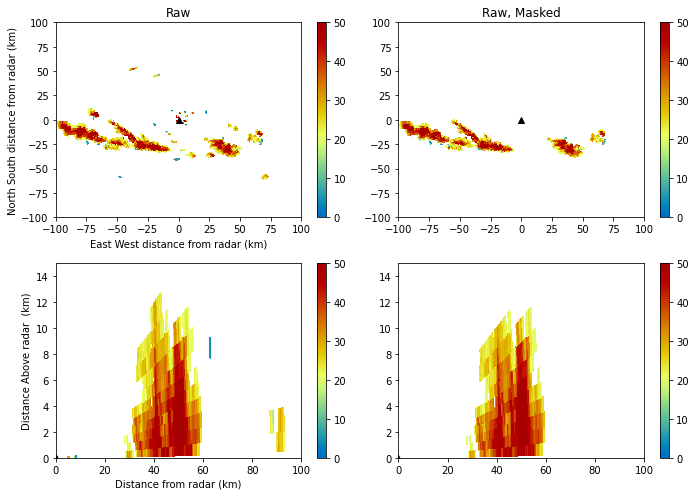

In [114]:
# plot in radar coordinates

gb = ((0,15), (-100,100), (-100,100))
rlim = (0,100)
tilt, ray, vmin, vmax = 0,130, 0, 50

display = pyart.graph.RadarDisplay(radar)
fig = plt.figure(figsize=(10, 7))

ax = fig.add_subplot(221)
ax.plot(0,0, 'k^')
display.plot_ppi(field+'_original', tilt, ax=ax,colorbar_flag= True,
             colorbar_label='',vmin = vmin, vmax = vmax, title=  'Raw',cmap = 'pyart_HomeyerRainbow')
display.set_limits(gb[2], gb[1], ax=ax)

ax = fig.add_subplot(222)
ax.plot(0,0, 'k^')

display.plot_ppi(field+'', tilt, ax=ax,colorbar_flag= True, axislabels_flag = False,
             colorbar_label='',vmin = vmin, vmax = vmax, title=  'Raw, Masked',cmap = 'pyart_HomeyerRainbow')
display.set_limits(gb[2], gb[1], ax=ax)

xsect = pyart.util.cross_section_ppi(radar, [ray])
display = pyart.graph.RadarDisplay(xsect)

ax = fig.add_subplot(223)
ax.plot(0,0, 'k^')

display.plot(field+'_original', 0, colorbar_flag= True, vmin = vmin, vmax = vmax,colorbar_label='',
             title=  '',cmap = 'pyart_HomeyerRainbow')
display.set_limits(rlim, gb[0], ax=ax)
display = pyart.graph.RadarDisplay(xsect)

ax = fig.add_subplot(224)
ax.plot(0,0, 'k^')

display.plot(field+'', 0, colorbar_flag= True, vmin = vmin, vmax = vmax, title=  '',colorbar_label='',
             axislabels_flag = False,cmap = 'pyart_HomeyerRainbow')
display.set_limits(rlim, gb[0], ax=ax)

plt.tight_layout()
plt.show()

# Gridding

In [115]:
gs = (31, 201, 201)
gb = ((0, 15000), (-100000,100000),(-100000,100000))
center_pos = (0,0,0)
lon0, lat0 = radar.longitude['data'][0], radar.latitude['data'][0]

x = np.linspace(gb[2][0],gb[2][1], gs[2])
y = np.linspace(gb[1][0],gb[1][1], gs[1])
z = np.linspace(gb[0][0],gb[0][1], gs[0])
coords = (z-center_pos[0], y-center_pos[1], x-center_pos[2])

def leroy_grid(radar,coords, field):
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")
        return leroy.cressman_ppi_interp(radar, coords, field, k=200, verbose=True, filter_its = 0, corr_lens = (800, 2000))
def const_cressman(radar, field):
    grid = pyart.map.grid_from_radars((radar,), grid_origin = (lat0, lon0), grid_shape=gs, roi_func = 'constant', constant_roi = 2400,
                                      weighting_function = 'Cressman',grid_limits=gb, fields=[field])
    return grid.fields[field]['data']

In [116]:
f_leroy = leroy_grid(radar,coords, field)
f_const = const_cressman(radar, field)

Radius of influence set to 2389.0342400103436 m.
Interpolating...
Done!


/home/564/jb2354/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  after removing the cwd from sys.path.
/home/564/jb2354/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  if __name__ == '__main__':


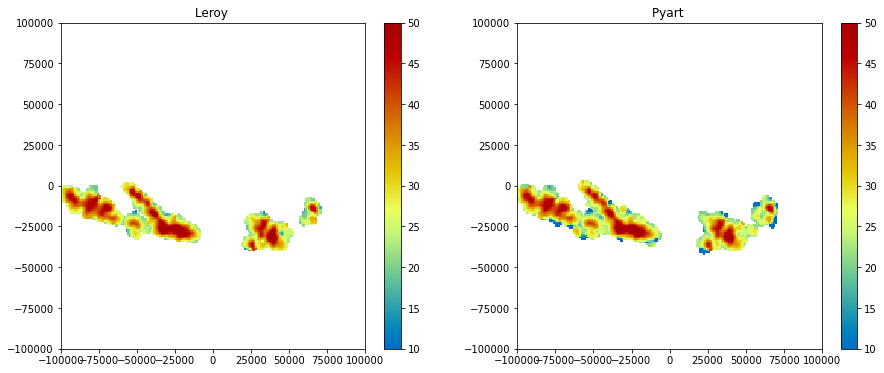

In [119]:
zidx = 5
fig = plt.figure(figsize=(15, 6))
ax = fig.add_subplot(121)
m = ax.pcolormesh(x,y,f_leroy[zidx,...], cmap ='pyart_HomeyerRainbow', vmin = 10, vmax = 50)
plt.colorbar(m)
ax.set_title('Leroy ')

ax = fig.add_subplot(122)
m = ax.pcolormesh(x,y,f_const[zidx,...], cmap ='pyart_HomeyerRainbow', vmin = 10, vmax = 50)
plt.colorbar(m)
ax.set_title('Pyart ')
plt.show()

/home/564/jb2354/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  after removing the cwd from sys.path.
/home/564/jb2354/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  


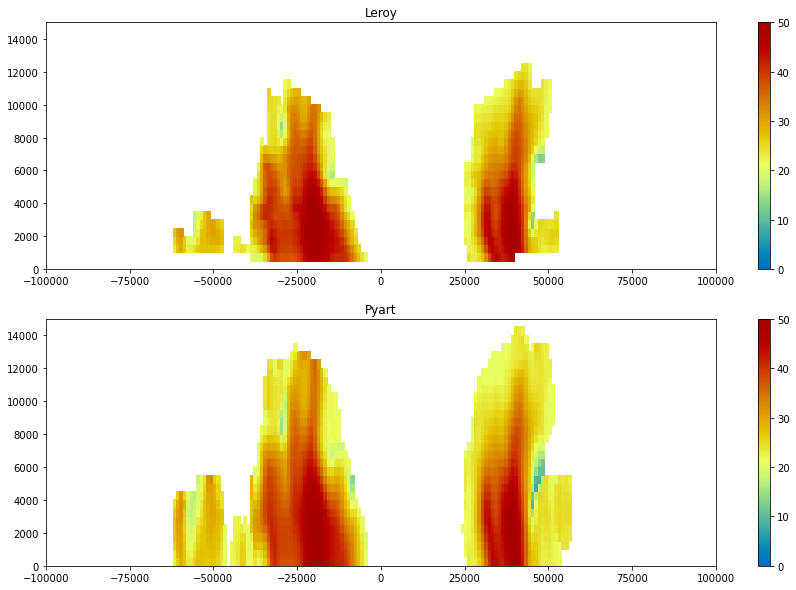

In [120]:
yidx = 70
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(211)
m = ax.pcolormesh(x,z,f_leroy[:,yidx,:], cmap ='pyart_HomeyerRainbow', vmin = 0, vmax = 50)
plt.colorbar(m)
ax.set_title('Leroy')
ax = fig.add_subplot(212)
m = ax.pcolormesh(x,z,f_const[:,yidx,:], cmap ='pyart_HomeyerRainbow', vmin = 0, vmax = 50)
plt.colorbar(m)
ax.set_title('Pyart')

plt.show()